# **Ações PETR4.SA: Previsões em Séries Temporais**

# Tabela de Conteúdos

1. [Dependências](#scrollTo=X1ljCqaY7Rl2)
2. [Médias Móveis Simples](#scrollTo=KsHdoR766r_R)
    1. [SMA10, SMA30 & SMA50](#scrollTo=PMupnQE765ai)

3. [Modelos Estatísticos](#scrollTo=jNEIXUQX66ce)
    1. [Autorregressivo (AR)](#scrollTo=Ykk4RxUzCVuW)
    2. [ARMA(2,0,2)](#scrollTo=BweXWLdJ6xCs)
    3. [ARIMA(5,0,2)](#scrollTo=soKDM9NM9opm)

4. [Modelos Ingênuos](#scrollTo=HGjMNYiv6mFb)
    1. [Naive1 & Naive5](#scrollTo=egPrpER29sTt)

5. [Redes Neurais](#scrollTo=Y9jLczRD6fnM)
    1. [Convolutional Neural Network (CNN)](#scrollTo=cVZubAZKRcyt)
    2. [Long Short-Term Memory (LSTM)](#scrollTo=OT5RmKW39un8)

6. [Simulações de *trading*](#scrollTo=xIyeao4C9J46)
    1. [Autorregressivo (AR)](#scrollTo=upT3WbuRbWHK)
    2. [ARMA(2,0,2)](#scrollTo=1jS6yjD2Pr2r)
    3. [ARIMA(5,0,2)](#scrollTo=ax3I1uuMPuE-)
    4. [CNN](#scrollTo=LTWavNl2bZRJ)
    5. [LSTM](#scrollTo=qirFjhIQP2rE)

7. [Resultados](#scrollTo=iyKd34PIQb7M)
    1. [Modelos](#scrollTo=uA1iJ_6OjMZU)
    2. [Operações de *trading*](#scrollTo=WtQnuMpsjQdJ)

# Dependências

In [1]:
from google.colab import drive

# Fazendo mount no Drive para acessar os dados das cotações
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
# Imports gerais
import matplotlib.pyplot as plt
import numpy as np

# Pré processamento de dados
from sklearn.preprocessing import MinMaxScaler

# Métricas
from sklearn.metrics import accuracy_score          # Acurácia
from sklearn.metrics import r2_score                # R2
from sklearn.metrics import mean_squared_error      # MSE

In [3]:
#Plot configs
plt.rcParams["figure.figsize"] = (18,6)

## Funções auxiliares

### Classificação de movimentos

In [4]:
def classificate_movs(predicted: list) -> list:
    """
    Compara os valores previstos com os valores reais de fechamento e gera 
    classificações de subida ou queda.

    Params:
        list predicted: lista com os valores previstos

    Returns:
        list pred_movs: lista com os movimentos, sendo o primeiro elemento None
    """

    pred_movs = []

    for i in range(len(predicted)-1):
        if predicted[i+1] > predicted[i]:
            pred_movs.append("Up")
        elif predicted[i+1] < predicted[i]:
            pred_movs.append("Down")
        else:
            pred_movs.append("Up")

    pred_movs.append(None)
    return pred_movs

### Salvar dados

In [5]:
def save_data(*data, 
              labels: list, 
              model: str, 
              dictionary: dict) -> dict:

    """Função que salva em um dicionário dados específicos, 
    cujas labels das linhas são passados em uma lista 
    (parâmetro labels).

    Params:
        *data: dados a serem salvados
        labels: labels que correspondem às métricas utilizadas
        model: modelo em questão, que será alocado na coluna
        dictionary: variável utilizada para armazenar os dados

    Returns:
        dictionary: mesmo dicionário passado no parâmetro, porém
        atualizado com os dados.
    """

    dictionary[model] = {}
    for l, i in zip(labels, data):
        dictionary[model][l] = i

    print(f"{model} Salvado com sucesso!")
    return dictionary

### Operações de *trading*

In [6]:
def classifications_trading(closes: list, 
                            predicted_movements: list,
                            model: str,
                            n: int = 1500,
                            wallet: float = 100000.00,
                            show_results=False) -> list:
    
    """
    Algoritmo para realizar operações de trading com base em movimentos diários
    previstos para uma ação em um determinado intervalo temporal.

    Algoritmo:
        A partir do PRIMEIRO DIA até o ÚLTIMO DIA:
            Se o close previsto hoje para AMANHÃ É ALTA e ontem para HOJE É ALTA:
                Se comprado:
                    MANTER COMPRADO
                Se não comprado:
                    COMPRAR HOJE próximo do fechamento
            Se o close previsto hoje para AMANHÃ É BAIXA:
                Se comprado:
                    VENDER HOJE próximo do fechamento
                Se não comprado:
                    MANTER SEM COMPRAR

    Params:
        closes: valores reais de fechamento de uma ação
                predicted_movements: movimentos previstos, com base nos preços de 
                fechamento
        previstos por um modelo preditivo
        model: nome do modelo utilizado nas previsões
        n: número de ações compradas em cada negociação. Por padrão, é 1500 unidades
        wallet: valor inicial da carteira disponível para negociações. Por padrão,
                é inicialmente R$ 100.000,00
        show_results: caso True, exibe os resultados através da função 
                      'show_operation_results'. Por padrão, Falso.
    
    Returns:
        Retorna uma lista com métricas específicas após a finalização da operação
        de trading. Acerca das métricas presentes na lista, são elas:

        model: nome do modelo preditivo;
        initial_wallet: valor da carteira inicial;
        wallet: valor da carteira final, após as operações;
        walls_diff: diferença numérica entre as carteiras inicial e final;
        walls_percent_diff: diferença percentual entre as carteiras inicial e final;
        score: número de operações com lucro;
        loss: número de operações com prejuízo;
        accuracy: acurácia das operações com lucro;
        mean_gain: ganho médio nas operações com lucro;
        [buys, sells, gains]: respectivamente: lista com compras, vendas e ganhos (BRL)
    """

    # Inicialização das variáveis
    initial_wallet = wallet
    sells = []
    buys = []
    gains = []
    buyed = False

    score = 0
    loss = 0

    for i in range(0, len(closes)):                              # Para todos os dias, do segundo ao último:
        if i == len(closes) - 1:
            wallet += last_buy                                   # Junta as quantias
            buys.append(np.nan)
            sells.append(np.nan)
            gains.append(np.nan)
        if predicted_movements[i] == "Up":                       # Se o close previsto de hoje for de alta:
            if buyed:                                            # Se já esta comprado:
                buys.append(np.nan)
                sells.append(np.nan)
                gains.append(np.nan)
                continue                                         # Mantém comprado
            else:                                                # Se não esta comprado:
                if wallet > closes[i]*n:                         # E se tiver dinheiro pra comprar:
                    wallet -= closes[i]*n                        # Compra uma ação
                    buyed = True
                    buys.append(closes[i])
                    sells.append(np.nan)
                    gains.append(np.nan)
                    last_buy = closes[i]*n
        elif predicted_movements[i] == "Down":                  # Se o close previsto de hoje for de baixa:
            if buyed:                                           # Se já esta comprado:
                if wallet > closes[i]*n:                        # Se tiver ações na carteira:
                        wallet += closes[i]*n                   # Vende uma ação
                        buyed = False
                        sells.append(closes[i])
                        buys.append(np.nan)
                        gains.append(closes[i]*n - last_buy)
                        if gains[-1] > 0:
                            score += 1
                        else:
                            loss += 1
                        last_buy = 0
                else:
                    buys.append(np.nan)
                    sells.append(np.nan)
                    gains.append(np.nan)
            else:                                               # Se não esta comprado
                buys.append(np.nan)
                sells.append(np.nan)
                gains.append(np.nan)
                continue                                        # Mantém sem comprar

    walls_diff = wallet - initial_wallet
    walls_percent_diff = wallet / initial_wallet
    accuracy = score / (score + loss)
    n_gains = [i for i in gains if isinstance(i, np.float64)]
    mean_gain = sum(n_gains) / len(n_gains)

    # Lista de retorno com as métricas
    returns = [
        model,
        initial_wallet,
        wallet,
        walls_diff,
        walls_percent_diff,
        score,
        loss,
        accuracy,
        mean_gain,
        [buys, sells, gains]]

    if show_results == True:
        show_operation_results(returns)

    return returns

In [7]:
def show_operation_results(r: list) -> None:
    """
    Exibe os resultados das métricas após uma operação de trading

    Params:
        r: lista com as métricas de saída da função 'classifications_trading'

    Returns:
        None
    """

    print("-" *2**6)
    
    print("+" + ("-" * len(r[0])) + "--+")
    print(f"| {r[0]} |")
    print("+" + ("-" * len(r[0])) + "--+")

    print(f"Initial Wallet: {r[1]}")
    print(f"Final Wallet: {r[2]}")
    print(f"Wallets Diff: {r[3]}")
    print(f"Percentage Wallets diff: {r[4]}")
    print(f"Score: {r[5]}")
    print(f"Loss: {r[6]}")
    print(f"Hits Accuracy: {r[7]}")
    print(f"Mean Gain: {r[8]}")
    print("-" *2**6)

In [8]:
def operation_plot(
        actual_prices,
        buys_sells,
        model,
        predicted_prices=None):
    
    """
    Realiza a plotagem visual das compras e vendas de uma determinada
    operação de trading.

    Params:
        actual_prices: preços reais de fechamentos de uma determinada ação
        buys_sells: último elemento da lista de retorno da função
                    'classifications_trading', após a operação
        model: nome do modelo preditivo
        predicted_prices: lista de preços previstos pelo modelo no período
                          em questão.

    Returns:
        None
    """

    # Preços reais
    plt.plot(range(len(buys_sells[0])), 
             actual_prices, 
             color='orange', 
             label='Close PETR4.SA')
    
    # Preços previstos
    plt.plot(range(len(buys_sells[0])), 
             predicted_prices, 
             color='lightgreen', 
             alpha=0.8, 
             label='Preços previstos PETR4.SA')
    
    # Compras
    plt.scatter(range(len(buys_sells[0])), 
                buys_sells[0], 
                label="Buy", 
                marker="^", color="green")
    
    # Vendas
    plt.scatter(range(len(buys_sells[0])),
                buys_sells[1], 
                label="Sell", 
                marker="v", 
                color="red")
    
    plt.title(f'Classifications Trading com Previsões {model} - PETR4.SA')
    plt.xlabel('Data (2019)')
    plt.ylabel('Preços (BRL)')
    plt.grid(linestyle="-.")

    plt.legend(['Preço real de fechamento', 
                'Preço de fechamento previsto', 
                "Compra", 
                "Venda"])

    plt.show()

## Dicionários para salvar os resultados

In [9]:
# Inicialização da variável em que serão armazenados os dados dos modelos
# Dados armazenados: Acurácia, MSE e R2, nesta ordem
models_results = {}

# Inicialização da variável em que serão armazenados os resultados das
# operações de trading dos modelos
trading_results = {}

# Adicionando métricas para cada modelo
for i in models_results:
    models_results[i] = {"Accuracy": "", "MSE": "", "R2": ""}

# Adicionando campos de regressão e classificação para cada modelo
for i in trading_results:
    trading_results[i] = {"Final Wallet": "", \
                          "Wallets Diff": "", \
                          "% Wallets Diff": "", \
                          "Score": "", \
                          "Loss": "", \
                          "Hits Accuracy": "", \
                          "Mean Gain": ""}

## Carregando os dados

In [10]:
import pandas as pd

# Carregando dados do Drive
dataset = 'drive/MyDrive/datasets/stocks/PETR4.SA.csv'
df = pd.read_csv(dataset)

In [11]:
# Limpando os dados
# Eliminando linhas com NaN
df = df.dropna()

# Adicionando coluna com movimentos das ações
df_mov = classificate_movs(df.Close.values) # Classificando os movimentos
df["Mov"] = df_mov

# Colocando a coluna de data como index da tabela
df.set_index(df.Date, inplace=True)

In [12]:
# Header dos dados
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mov
Date,,,,,,,,
2000-01-03,2000-01-03,5.875,5.875,5.875,5.875,3.812799,3.538944e+10,Down
2000-01-04,2000-01-04,5.550,5.550,5.550,5.550,3.601876,2.886144e+10,Down
2000-01-05,2000-01-05,5.494,5.494,5.494,5.494,3.565535,4.303360e+10,Down
2000-01-06,2000-01-06,5.475,5.475,5.475,5.475,3.553203,3.405568e+10,Up
2000-01-07,2000-01-07,5.500,5.500,5.500,5.500,3.569429,2.091264e+10,Up


In [13]:
# Criando um novo df para as cotações de 2019
tr = df[(df.Date > '2016-12-31') & (df.Date < '2019-01-01')] # Dados de treino (2017 e 2018)
te = df[(df.Date > '2018-12-31') & (df.Date < '2020-01-01')] # Dados de teste (2019)

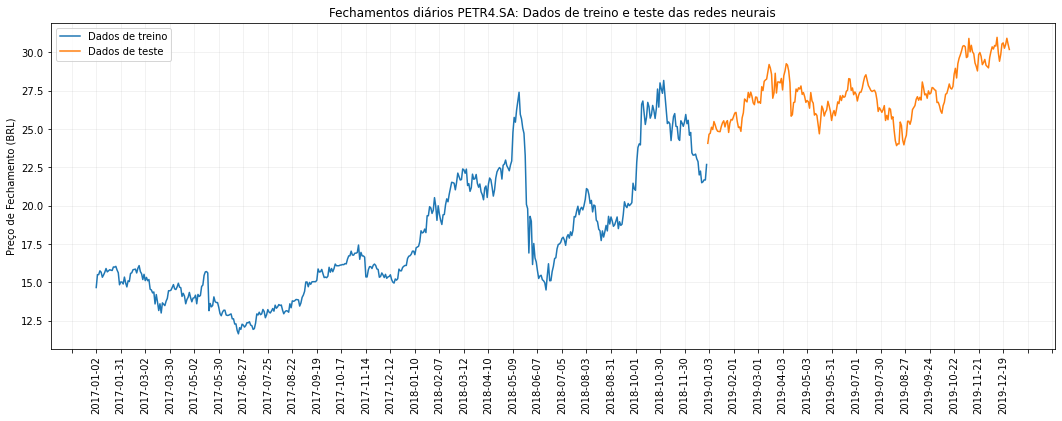

In [14]:
# Visualizando os dados
plt.plot(tr.Close)
plt.plot(te.Close)

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(20))
plt.xticks(rotation=90)
plt.ylabel("Preço de Fechamento (BRL)")

plt.title("Fechamentos diários PETR4.SA: Dados de treino e teste das redes neurais")
plt.grid(alpha=.2)

plt.legend(["Dados de treino", "Dados de teste"])

In [15]:
# Dados de Teste
actual_prices = te['Close'].values      # Preços de fechamento (Close)
real_movs = te.Mov.values               # Movimentos dos preços de fechamento (Close)
all_data = pd.concat([tr, te])          # Concatenando os dados de treino e teste

# Médias Móveis Simples

Um modelo de Médias Móveis Simples (MMS) ou SMA (*Simple Moving Average*) pode ser definido como:

$$ {\begin{aligned}{\overline {\rm {\textit{p}}}}_{i}&={\frac {p_{i+1}+\cdots +p_{i+n}}{n}}\\&={\frac {1}{n}}\sum _{j=1}^{n}p_{i+j}\end{aligned}} $$

Onde $ n $ é a quantidade de elementos passados a serem considerados.

Temos que:
- SMA10 é a MMS com $ n $ igual a 10;
- SMA30 é a MMS com $ n $ igual a 30;
- SMA50 é a MMS com $ n $ igual a 50;

## SMA10, SMA30 & SMA50

In [16]:
# Partindo do conjunto dos dados concatenados para isolar as previsões
# no período de 2019, de maneira comparativa
sma_10 = all_data[-257:].Close.rolling(10).mean() # Média móvel de 10 dias
sma_30 = all_data[-277:].Close.rolling(30).mean() # Média móvel de 30 dias
sma_50 = all_data[-297:].Close.rolling(50).mean() # Média móvel de 50 dias

In [17]:
sma10_class = classificate_movs(sma_10) # Classificando movimentos com base nas previsões SMA10
sma30_class = classificate_movs(sma_30) # Classificando movimentos com base nas previsões SMA30
sma50_class = classificate_movs(sma_50) # Classificando movimentos com base nas previsões SMA50

# Mean Squared Error (MSE) das previsões numéricas
# Partindo da posição onde se excluem os elementos iniciais usados nas SMAs
sma10_mse = ((sma_10[10:] - te.Close.values)**2).mean()
sma30_mse = ((sma_30[30:] - te.Close.values)**2).mean()
sma50_mse = ((sma_50[50:] - te.Close.values)**2).mean()

# Acurácia dos movimentos previstos
# Acurácias calculadas excluindo os valores iniciais das médias móveis
# Excluindo também o último elemento, pois não tem "movimento"
sma10_accuracy = accuracy_score(te.Mov[:-1], sma10_class[10:-1]) # Da posição 10 até a penúltima
sma30_accuracy = accuracy_score(te.Mov[:-1], sma30_class[30:-1]) # Da posição 30 até a penúltima
sma50_accuracy = accuracy_score(te.Mov[:-1], sma50_class[50:-1]) # Da posição 50 até a penúltima

# R2
sma10_r2 = r2_score(te.Close.values, sma_10[10:]) # Da posição 10 até a penúltima
sma30_r2 = r2_score(te.Close.values, sma_30[30:]) # Da posição 30 até a penúltima
sma50_r2 = r2_score(te.Close.values, sma_50[50:]) # Da posição 50 até a penúltima

print("+---------------------------------+")
print("| Resultados SMA10, SMA30 & SMA50 |")
print("+---------------------------------+")

print(f"\nSMA10 MSE: \t\t{sma10_mse}")
print(f"SMA30 MSE: \t\t{sma30_mse}")
print(f"SMA50 MSE: \t\t{sma50_mse}\n")

print(f"\nSMA10 R2: \t\t{sma10_r2}")
print(f"SMA30 R2: \t\t{sma30_r2}")
print(f"SMA50 R2: \t\t{sma50_r2}\n")

print(f"SMA10 Accuracy: \t{sma10_accuracy}")
print(f"SMA30 Accuracy: \t{sma30_accuracy}")
print(f"SMA50 Accuracy: \t{sma50_accuracy}")

+---------------------------------+
| Resultados SMA10, SMA30 & SMA50 |
+---------------------------------+

SMA10 MSE: 		0.550164568944476
SMA30 MSE: 		1.3928544292302332
SMA50 MSE: 		2.0681854790242395


SMA10 R2: 		0.7984600152523552
SMA30 R2: 		0.48976019855055164
SMA50 R2: 		0.24236838679462025

SMA10 Accuracy: 	0.5894308943089431
SMA30 Accuracy: 	0.540650406504065
SMA50 Accuracy: 	0.5203252032520326


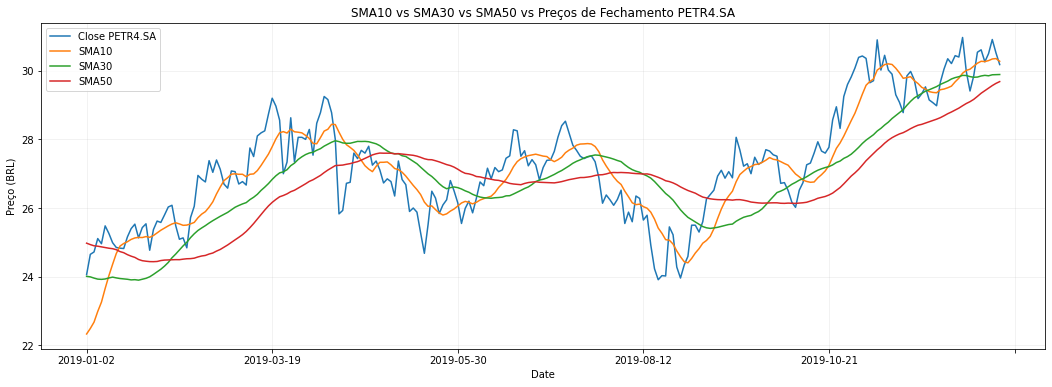

In [18]:
# Plotagem de gráfico
te.Close.plot()
sma_10[10:].plot()  # Excluindo primeiros 10 dias usados na SMA10
sma_30[30:].plot()  # Excluindo primeiros 30 dias usados na SMA30
sma_50[50:].plot()  # Excluindo primeiros 50 dias usados na SMA50

plt.title("SMA10 vs SMA30 vs SMA50 vs Preços de Fechamento PETR4.SA")
plt.grid(alpha=.2)
plt.ylabel("Preço (BRL)")

plt.legend(["Close PETR4.SA", "SMA10", "SMA30", "SMA50"])

In [19]:
# Salvando resultados em um dicionário
models_results = save_data(sma10_accuracy, 
                           sma10_mse, 
                           sma10_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="SMA10", dictionary=models_results) # SMA10

models_results = save_data(sma30_accuracy,
                           sma30_mse, 
                           sma30_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="SMA30", dictionary=models_results) # SMA30

models_results = save_data(sma50_accuracy, 
                           sma50_mse, 
                           sma50_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="SMA50", dictionary=models_results) # SMA50

SMA10 Salvado com sucesso!
SMA30 Salvado com sucesso!
SMA50 Salvado com sucesso!


# Modelos Estatísticos

In [20]:
# Modelos estatísticos
from statsmodels.tsa.arima_model import ARMA    # Modelo ARMA
from statsmodels.tsa.arima_model import ARIMA   # Modelo ARIMA
from statsmodels.tsa.ar_model import AR         # Modelo AR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Autorregressivo (AR)

Um modelo Autorregressivo $AR(p)$ indica um modelo de ordem $p$, definido como:

$$ X_{t}=c+\sum _{{i=1}}^{p}\varphi _{i}X_{{t-i}}+\varepsilon _{t} $$

Onde:
- $ \varphi _{1},\ldots ,\varphi _{p} $ são os parâmetros do modelo;
- $ c $ é uma constante;
- $ \varepsilon _{t} $ é o ruído branco.


In [21]:
ar = AR(all_data[-367:].Close).fit(120)   # Declarando e treinando o modelo com 120 dias anteriores
ar_pred = ar.predict()                    # Realizando as previsões

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [22]:
# Classificando os movimentos com base nas previsões numéricas
ar_class = classificate_movs(ar_pred)

ar_mse = ((ar.resid)**2).mean()                                 # MSE das previsões
ar_accuracy = accuracy_score(te.Mov[:-1], ar_class[:-1])        # Acurácia dos movimentos
ar_r2 = r2_score(actual_prices, ar_pred)                        # R2 das previsões

print("+-------------------------+")
print("| Resultados do modelo AR |")
print("+-------------------------+")

print(f"\nAR MSE: \t{ar_mse}")
print(f"AR R2: \t\t{ar_r2}")
print(f"AR Accuracy: \t{ar_accuracy}\n")

+-------------------------+
| Resultados do modelo AR |
+-------------------------+

AR MSE: 	0.12630973256482875
AR R2: 		0.9537293693350075
AR Accuracy: 	0.6260162601626016



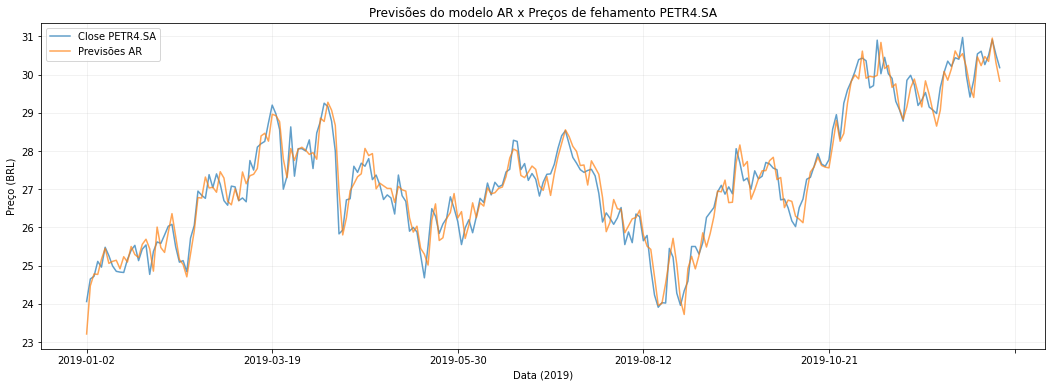

In [23]:
# Plotagem de gráfico
te.Close.plot(alpha=.7)
ar_pred.plot(alpha=.7)

plt.title("Previsões do modelo AR x Preços de fehamento PETR4.SA")
plt.ylabel("Preço (BRL)")
plt.xlabel("Data (2019)")
plt.grid(alpha=.2)
plt.legend(["Close PETR4.SA", "Previsões AR"])

In [24]:
# Salvando resultados em um dicionário
models_results = save_data(ar_accuracy, 
                           ar_mse, 
                           ar_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="AR", dictionary=models_results) # AR

AR Salvado com sucesso!


## ARMA(2,0,2)

A notação ARMA($ p,q $) se refere ao modelo com termos auto-regressivos $p$ e termos de média móvel $q$. Este modelo contém os modelos AR($p$) e SMA($q$):

$$ X_{t}=c+\varepsilon _{t}+\sum _{i=1}^{p}\varphi _{i}X_{t-i}+\sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}$$

Combinando o modelo de Médias Móveis:

$$ X_{t}=\mu +\varepsilon _{t}+\sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i} $$

Com o modelo Autorregressivo:

$$ X_{t}=c+\sum _{{i=1}}^{p}\varphi _{i}X_{{t-i}}+\varepsilon _{t} $$

In [25]:
arma = ARMA(te.Close, order=(2,0,2)).fit()  # Declarando e treinando o modelo
arma_pred = arma.predict()                  # Realizando as previsões

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [26]:
# Classificando os movimentos com base nas previsões numéricas
arma_class = classificate_movs(arma_pred)

arma_mse = (arma.resid ** 2).mean()                             # MSE das previsões
arma_accuracy = accuracy_score(te.Mov[:-1], arma_class[:-1])    # Acurácia dos movimentos
arma_r2 = r2_score(actual_prices[:-1], arma_pred[:-1])          # R2 das previsões

print("+---------------------------+")
print("| Resultados do modelo ARMA |")
print("+---------------------------+")

print(f"\nARMA(2,0,2) MSE: \t{arma_mse}")
print(f"ARMA(2,0,0) Accuracy: \t{arma_accuracy}")
print(f"ARMA(2,0,0) R2: \t{arma_r2}")

+---------------------------+
| Resultados do modelo ARMA |
+---------------------------+

ARMA(2,0,2) MSE: 	0.27221192462508853
ARMA(2,0,0) Accuracy: 	0.491869918699187
ARMA(2,0,0) R2: 	0.899076002698399


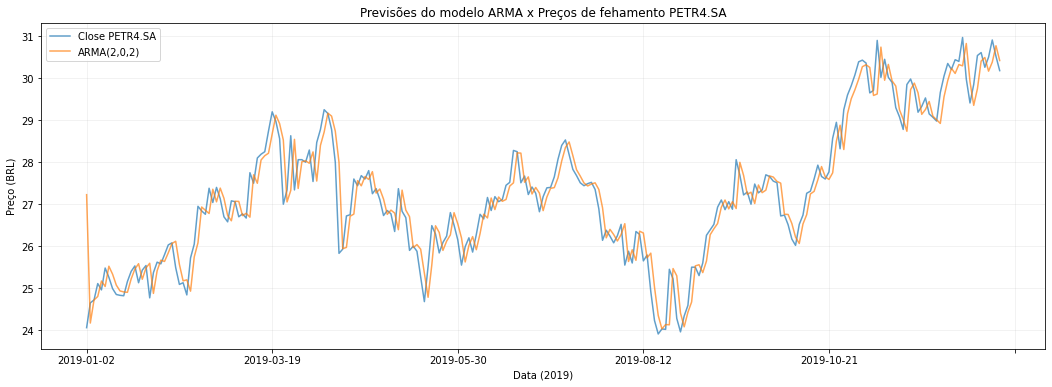

In [27]:
# Plotagem de gráfico
te.Close.plot(alpha=.7)
arma_pred.plot(alpha=.7)

plt.grid(alpha=.2)
plt.title("Previsões do modelo ARMA x Preços de fehamento PETR4.SA")
plt.ylabel("Preço (BRL)")
plt.xlabel("Data (2019)")
plt.legend(["Close PETR4.SA", "ARMA(2,0,2)"])

In [28]:
# Salvando resultados em um dicionário
models_results = save_data(arma_accuracy, 
                           arma_mse, 
                           ar_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="ARMA(2,0,2)", dictionary=models_results) # ARMA

ARMA(2,0,2) Salvado com sucesso!


## ARIMA(5,0,2)

Um processo ARIMA($ p, d, q $) expressa a propriedade de fatoração deste polinômio com $ p=p'-d $, sendo dado por:

$$ \left(1-\sum _{i=1}^{p}\phi _{i}L^{i}\right)(1-L)^{d}X_{t}=\left(1+\sum _{i=1}^{q}\theta _{i}L^{i}\right)\varepsilon _{t} $$

In [29]:
arima = ARIMA(all_data[-249:].Close, order=(5,2,0)).fit()    # Declarando e treinando o modelo
arima_pred = arima.predict(typ='levels')                     # Realizando as previsões

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [30]:
# Classificando os movimentos com base nas previsões numéricas
arima_class = classificate_movs(arima_pred)

arima_mse = (arima.resid ** 2).mean()                               # MSE das previsões
arima_accuracy = accuracy_score(te.Mov[:-1], arima_class[:-1])      # Acurácia dos movimentos
arima_r2 = r2_score(actual_prices[:-1], arima_pred[:-1])            # R2 das previsões

print("+----------------------------+")
print("| Resultados do modelo ARIMA |")
print("+----------------------------+")

print(f"\nARIMA(5,2,0) MSE: \t{arima_mse}")
print(f"ARIMA(5,2,0) Accuracy: \t{arima_accuracy}")
print(f"ARIMA(5,2,0) R2: \t{arima_r2}")

+----------------------------+
| Resultados do modelo ARIMA |
+----------------------------+

ARIMA(5,2,0) MSE: 	0.2931339013796619
ARIMA(5,2,0) Accuracy: 	0.508130081300813
ARIMA(5,2,0) R2: 	0.8914714815338545


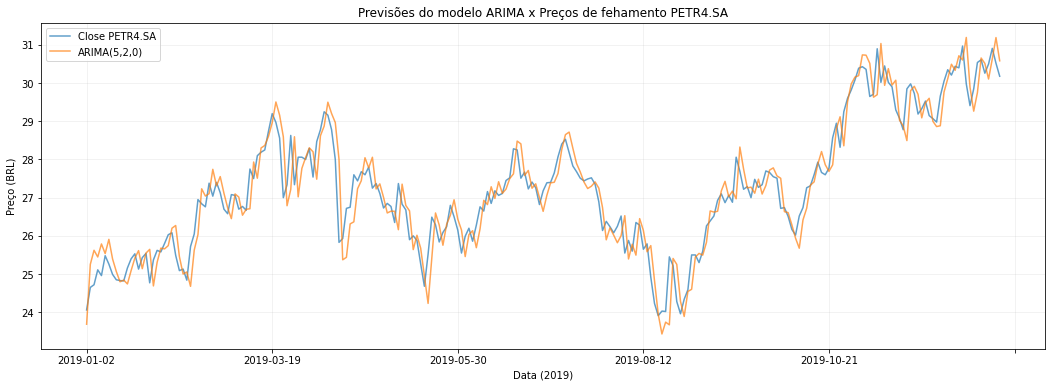

In [31]:
# Plotagem de gráfico
te.Close.plot(alpha=.7)
arima_pred.plot(alpha=.7)

plt.grid(alpha=.2)
plt.title("Previsões do modelo ARIMA x Preços de fehamento PETR4.SA")
plt.ylabel("Preço (BRL)")
plt.xlabel("Data (2019)")
plt.legend(["Close PETR4.SA", "ARIMA(5,2,0)"])

In [32]:
# Salvando resultados em um dicionário
models_results = save_data(arima_accuracy, 
                           arima_mse, 
                           arima_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="ARIMA(5,0,2)", dictionary=models_results) # ARIMA

ARIMA(5,0,2) Salvado com sucesso!


# Modelos Ingênuos

Modelos ingênuos são obtidos pela projeção dos dados do passado para o futuro. Neste caso, "deslocamos" os dados de fechamento em 1 e 5 unidades, respectivamente, assumindo ingenuamente que os dados do passado irão se repetir no futuro.

## Naive1 & Naive5

In [33]:
naive_1 = all_data[-248:].Close.shift(1)     # Modelo Naive com deslocamento de 1 unidade
naive_5 = all_data[-252:].Close.shift(5)     # Modelo Naive com deslocamento de 5 unidades

In [34]:
naive1_class = classificate_movs(naive_1[1:])   # Classificando os movimentos com base nas previsões do naive 1
naive5_class = classificate_movs(naive_5[5:])   # Classificando os movimentos com base nas previsões do naive 5

# MSE
naive1_mse = ((naive_1 - te.Close)**2).mean()  # MSE das previsões do naive 1
naive5_mse = ((naive_5 - te.Close)**2).mean()  # MSE das previsões do naive 5

# R2
naive1_r2 = r2_score(te.Close.values, naive_1[1:])  # R2 das previsões do naive 1
naive5_r2 = r2_score(te.Close.values, naive_5[5:])  # R2 das previsões do naive 5

# Ambos excluem o último dia, que não  possui movimento classificado
naive1_accuracy = accuracy_score(te.Mov[:-1], naive1_class[:-1])   # Excluindo o primeiro dia usado no shift
naive5_accuracy = accuracy_score(te.Mov[:-1], naive5_class[:-1])   # Excluindo os cinco primeioros dias usados no shift

print("+----------------------------+")
print("| Resultados Naive1 e Naive5 |")
print("+----------------------------+")

print(f"\nNaive1 MSE: \t\t{naive1_mse}")
print(f"Naive5 MSE: \t\t{naive5_mse}\n")

print(f"\nNaive1 R2: \t\t{naive1_r2}")
print(f"Naive5 R2: \t\t{naive5_r2}\n")

print(f"Naive1 Accuracy: \t{naive1_accuracy}")
print(f"Naive5 Accuracy: \t{naive5_accuracy}")

+----------------------------+
| Resultados Naive1 e Naive5 |
+----------------------------+

Naive1 MSE: 		0.2446923522275141
Naive5 MSE: 		1.0640779388671786


Naive1 R2: 		0.9103626519780929
Naive5 R2: 		0.610199813519362

Naive1 Accuracy: 	0.491869918699187
Naive5 Accuracy: 	0.5203252032520326


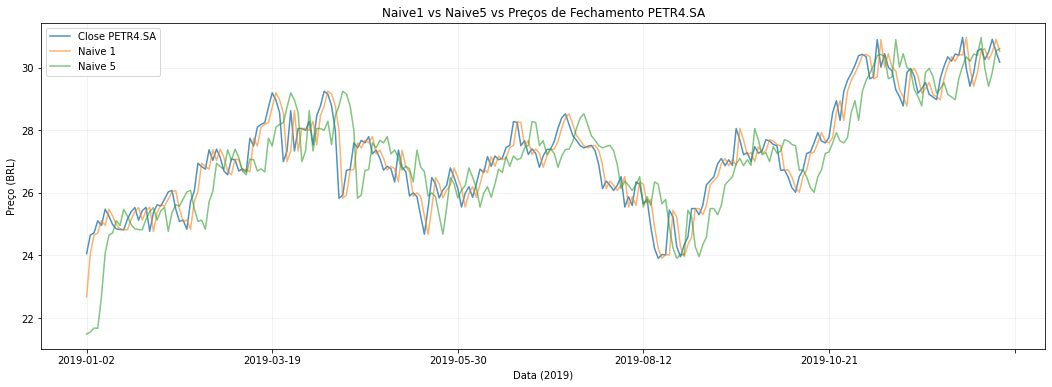

In [35]:
# Plotagem de gráfico
te.Close.plot(alpha=.8)
naive_1[1:].plot(alpha=.6)  # Excluindo o primeiro dia usado no shift
naive_5[5:].plot(alpha=.6)  # Excluindo os cinco primeioros dias usados no shift

plt.title("Naive1 vs Naive5 vs Preços de Fechamento PETR4.SA")
plt.grid(alpha=.2)
plt.ylabel("Preço (BRL)")
plt.xlabel("Data (2019)")

plt.legend(["Close PETR4.SA", "Naive 1", "Naive 5"])

In [36]:
# Salvando resultados em um dicionário
models_results = save_data(naive1_accuracy, 
                           naive1_mse, 
                           naive1_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="Naive1", dictionary=models_results) # Naive1

models_results = save_data(naive5_accuracy, 
                           naive5_mse, 
                           naive5_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="Naive5", dictionary=models_results) # Naive5

Naive1 Salvado com sucesso!
Naive5 Salvado com sucesso!


# Redes Neurais

In [37]:
# CNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [38]:
# Preparando os dados de entrada das redes neurais
scaler = MinMaxScaler(feature_range=(0,3))
scaled_data = scaler.fit_transform(tr['Close'].values.reshape(-1,1))

# Quantidade de dias passados tomados como base para realizar a previsão
prediction_days = 60

nn_x_train = []
nn_y_train = []

for x in range(prediction_days, len(scaled_data)):
    nn_x_train.append(scaled_data[x - prediction_days: x, 0])
    nn_y_train.append(scaled_data[x, 0])
    
nn_x_train, nn_y_train = np.array(nn_x_train), np.array(nn_y_train)
nn_x_train = np.reshape(nn_x_train, (nn_x_train.shape[0], nn_x_train.shape[1], 1))

In [39]:
# Concatenando dados de treino e teste
total_dataset = pd.concat((tr['Close'], te['Close']), axis=0)

model_inputs= total_dataset[len(total_dataset) - len(te) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

## Convolutional Neural Network (CNN)

In [40]:
# Declarando o modelo
model = Sequential()

# Camadas da rede
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')           # Compilando
model.fit(nn_x_train, nn_y_train, epochs=80, batch_size=60)          # Treinando

Epoch 1/80
8/8 [==============================] - 1s 47ms/step - loss: 2.2615
Epoch 2/80
8/8 [==============================] - 0s 44ms/step - loss: 0.4927
Epoch 3/80
8/8 [==============================] - 0s 44ms/step - loss: 0.2873
Epoch 4/80
8/8 [==============================] - 0s 46ms/step - loss: 0.1863
Epoch 5/80
8/8 [==============================] - 0s 43ms/step - loss: 0.1616
Epoch 6/80
8/8 [==============================] - 0s 46ms/step - loss: 0.1472
Epoch 7/80
8/8 [==============================] - 0s 45ms/step - loss: 0.1298
Epoch 8/80
8/8 [==============================] - 0s 44ms/step - loss: 0.1111
Epoch 9/80
8/8 [==============================] - 0s 43ms/step - loss: 0.0911
Epoch 10/80
8/8 [==============================] - 0s 43ms/step - loss: 0.0737
Epoch 11/80
8/8 [==============================] - 0s 46ms/step - loss: 0.0604
Epoch 12/80
8/8 [==============================] - 0s 45ms/step - loss: 0.0506
Epoch 13/80
8/8 [==============================] - 0s 44ms/st

In [41]:
cnn_x_test = []

for x in range(prediction_days, len(model_inputs)):
    cnn_x_test.append(model_inputs[x - prediction_days: x, 0])

cnn_x_test = np.array(cnn_x_test)
cnn_x_test = np.reshape(cnn_x_test, (cnn_x_test.shape[0], cnn_x_test.shape[1], 1))

# Realizando previsões
cnn_pred_prices = model.predict(cnn_x_test)
cnn_pred_prices = scaler.inverse_transform(cnn_pred_prices)

In [42]:
# Classificando os movimentos com base nas previsões numéricas
cnn_pred_movs = classificate_movs(cnn_pred_prices)

cnn_accuracy = accuracy_score(te.Mov.values[:-1], cnn_pred_movs[:-1])   # Acurácia dos movimentos 
cnn_r2 = r2_score(actual_prices, cnn_pred_prices)                       # R2 dos movimentos
cnn_mse = mean_squared_error(actual_prices, cnn_pred_prices)            # MSE das previsões

print("+----------------+")
print("| Resultados CNN |")
print("+----------------+")

print(f"\nCNN R2: \t{cnn_r2}")
print(f"CNN MSE: \t{cnn_mse}")
print(f"CNN Accuracy: \t{cnn_accuracy}")

+----------------+
| Resultados CNN |
+----------------+

CNN R2: 	-0.6324484446386729
CNN MSE: 	4.456263584584851
CNN Accuracy: 	0.5447154471544715


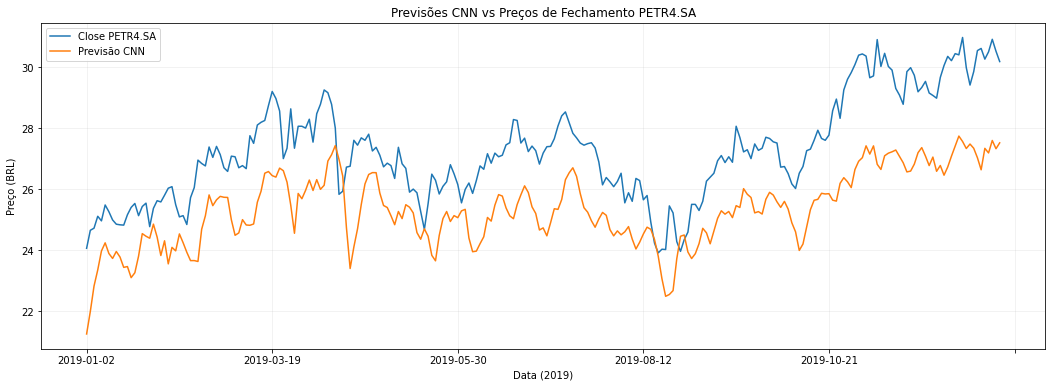

In [43]:
# Plotagem de gráfico
te.Close.plot()
plt.plot(cnn_pred_prices)

plt.grid(alpha=.2)
plt.title("Previsões CNN vs Preços de Fechamento PETR4.SA")
plt.legend(["Close PETR4.SA", "Previsão CNN"])
plt.ylabel("Preço (BRL)")
plt.xlabel("Data (2019)")

plt.show()

In [44]:
# Salvando resultados em um dicionário
models_results = save_data(cnn_accuracy, 
                           cnn_mse, 
                           cnn_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="CNN", dictionary=models_results) # CNN

CNN Salvado com sucesso!


## Long Short-Term Memory (LSTM)

In [45]:
# Declarando o modelo
model = Sequential()

# Camadas da rede
model.add(LSTM(units=60, return_sequences=True, input_shape=(nn_x_train.shape [1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=60))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss ='mean_squared_error')           # Compilando
model.fit(nn_x_train, nn_y_train, epochs=60, batch_size=30)           # Treinando  

Epoch 1/60
15/15 [==============================] - 6s 94ms/step - loss: 0.6477
Epoch 2/60
15/15 [==============================] - 1s 91ms/step - loss: 0.1922
Epoch 3/60
15/15 [==============================] - 1s 92ms/step - loss: 0.1098
Epoch 4/60
15/15 [==============================] - 1s 91ms/step - loss: 0.0990
Epoch 5/60
15/15 [==============================] - 1s 90ms/step - loss: 0.0821
Epoch 6/60
15/15 [==============================] - 1s 90ms/step - loss: 0.0737
Epoch 7/60
15/15 [==============================] - 1s 90ms/step - loss: 0.0620
Epoch 8/60
15/15 [==============================] - 1s 90ms/step - loss: 0.0598
Epoch 9/60
15/15 [==============================] - 1s 89ms/step - loss: 0.0492
Epoch 10/60
15/15 [==============================] - 1s 89ms/step - loss: 0.0514
Epoch 11/60
15/15 [==============================] - 1s 90ms/step - loss: 0.0405
Epoch 12/60
15/15 [==============================] - 1s 90ms/step - loss: 0.0450
Epoch 13/60
15/15 [==================

In [46]:
lstm_x_test = []

for x in range(prediction_days, len(model_inputs)):
    lstm_x_test.append(model_inputs[x - prediction_days: x, 0])

lstm_x_test = np.array(lstm_x_test)
lstm_x_test = np.reshape(lstm_x_test, (lstm_x_test.shape[0], lstm_x_test.shape[1], 1))

# Realizando previsões
lstm_pred_prices = model.predict(lstm_x_test)
lstm_pred_prices = scaler.inverse_transform(lstm_pred_prices)

In [47]:
# Classificando os movimentos com base nas previsões numéricas
lstm_pred_movs = classificate_movs(lstm_pred_prices)

lstm_accuracy = accuracy_score(te.Mov.values[:-1], lstm_pred_movs[:-1])     # Acurácia dos movimentos
lstm_r2 = r2_score(actual_prices, lstm_pred_prices)                         # R2 dos movimentos
lstm_mse = mean_squared_error(actual_prices, lstm_pred_prices)              # MSE das previsões

print("+-----------------+")
print("| Resultados LSTM |")
print("+-----------------+")

print(f"\nLSTM R2: \t{lstm_r2}")
print(f"LSTM MSE: \t{lstm_mse}")
print(f"LSTM Accuracy: \t{lstm_accuracy}")

+-----------------+
| Resultados LSTM |
+-----------------+

LSTM R2: 	0.5032006544455756
LSTM MSE: 	1.3561646248067492
LSTM Accuracy: 	0.524390243902439


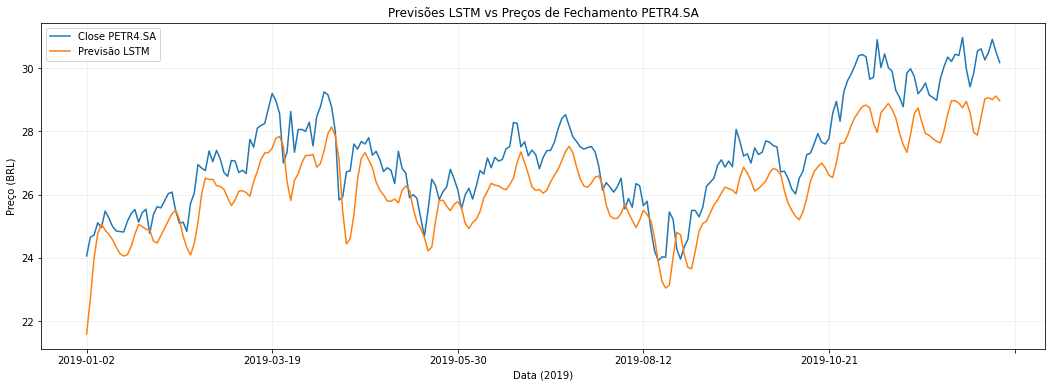

In [48]:
# Plotagem de gráfico
te.Close.plot()
plt.plot(lstm_pred_prices)

plt.grid(alpha=.2)
plt.title("Previsões LSTM vs Preços de Fechamento PETR4.SA")
plt.legend(["Close PETR4.SA", "Previsão LSTM"])
plt.ylabel("Preço (BRL)")
plt.xlabel("Data (2019)")

plt.show()

In [49]:
# Salvando resultados em um dicionário
models_results = save_data(lstm_accuracy, 
                           lstm_mse, 
                           lstm_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="LSTM", dictionary=models_results) # LSTM

LSTM Salvado com sucesso!


# Simulações de *trading*

## Autorregressivo (AR)

In [50]:
# Operação de trading com movimentos previstos AR
ar_trading = classifications_trading(actual_prices, 
                                     ar_class, 
                                     model="AR",
                                     show_results=True)

----------------------------------------------------------------
+----+
| AR |
+----+
Initial Wallet: 100000.0
Final Wallet: 134110.015
Wallets Diff: 34110.015000000014
Percentage Wallets diff: 1.3411001500000002
Score: 43
Loss: 23
Hits Accuracy: 0.6515151515151515
Mean Gain: 516.8184090909094
----------------------------------------------------------------


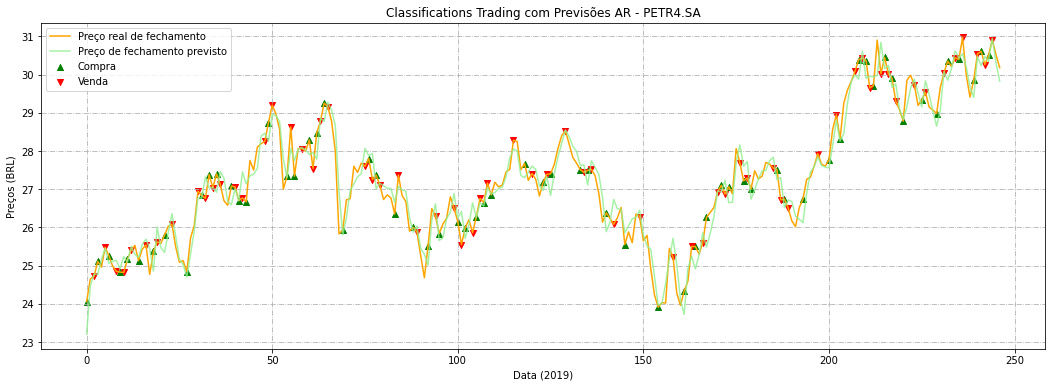

In [51]:
# Visualizando a operação AR
operation_plot(actual_prices, 
               ar_trading[-1],
               "AR",
               ar_pred)

In [52]:
# Salvando resultados em um dicionário
trading_results = save_data(ar_trading[2], 
                            ar_trading[3], 
                            ar_trading[4],
                            ar_trading[5],
                            ar_trading[6],
                            ar_trading[7],
                            ar_trading[8], 
                            
                            labels=["Final Wallet", 
                                    "Wallets Diff", 
                                    "% Wallets Diff",
                                    "Score",
                                    "Loss",
                                    "Hits Accuracy",
                                    "Mean Gain"],
                            
                            model="AR", 
                            dictionary=trading_results) # AR

AR Salvado com sucesso!


## ARMA(2,0,2)

In [53]:
# Operação de trading com movimentos previstos ARMA
arma_trading = classifications_trading(actual_prices, 
                                       arma_class,
                                       model="ARMA", 
                                       show_results=True)

----------------------------------------------------------------
+------+
| ARMA |
+------+
Initial Wallet: 100000.0
Final Wallet: 105564.99849999996
Wallets Diff: 5564.998499999958
Percentage Wallets diff: 1.0556499849999996
Score: 21
Loss: 41
Hits Accuracy: 0.3387096774193548
Mean Gain: 89.75804032258067
----------------------------------------------------------------


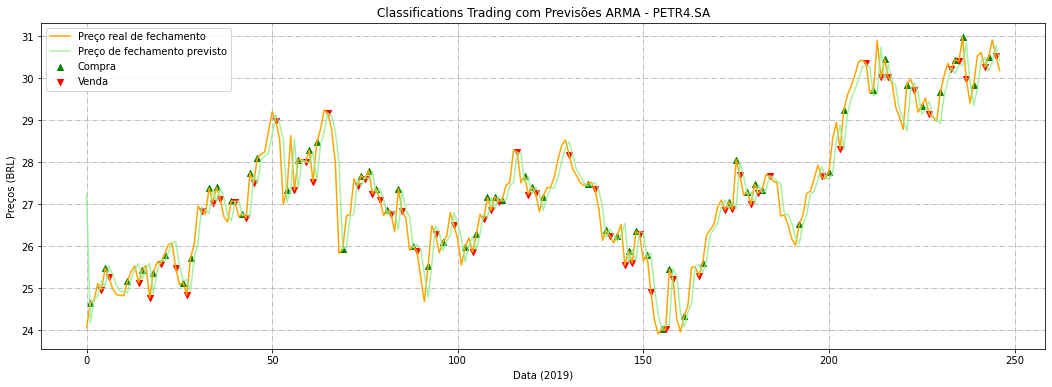

In [54]:
# Visualizando a operação ARMA
operation_plot(actual_prices, 
               arma_trading[-1],
               "ARMA",
               arma_pred)

In [55]:
# Salvando resultados em um dicionário
trading_results = save_data(arma_trading[2], 
                            arma_trading[3], 
                            arma_trading[4],
                            arma_trading[5],
                            arma_trading[6],
                            arma_trading[7],
                            arma_trading[8], 
                            
                            labels=["Final Wallet", 
                                    "Wallets Diff", 
                                    "% Wallets Diff",
                                    "Score",
                                    "Loss",
                                    "Hits Accuracy",
                                    "Mean Gain"],
                            
                            model="ARMA(2,0,2)", 
                            dictionary=trading_results) # ARMA

ARMA(2,0,2) Salvado com sucesso!


## ARIMA(5,0,2)

In [56]:
# Operação de trading com movimentos previstos ARIMA
arima_trading = classifications_trading(actual_prices, 
                                        arima_class,
                                        model="ARIMA", 
                                        show_results=True)

----------------------------------------------------------------
+-------+
| ARIMA |
+-------+
Initial Wallet: 100000.0
Final Wallet: 110709.99099999997
Wallets Diff: 10709.990999999965
Percentage Wallets diff: 1.1070999099999996
Score: 25
Loss: 38
Hits Accuracy: 0.3968253968253968
Mean Gain: 169.99985714285705
----------------------------------------------------------------


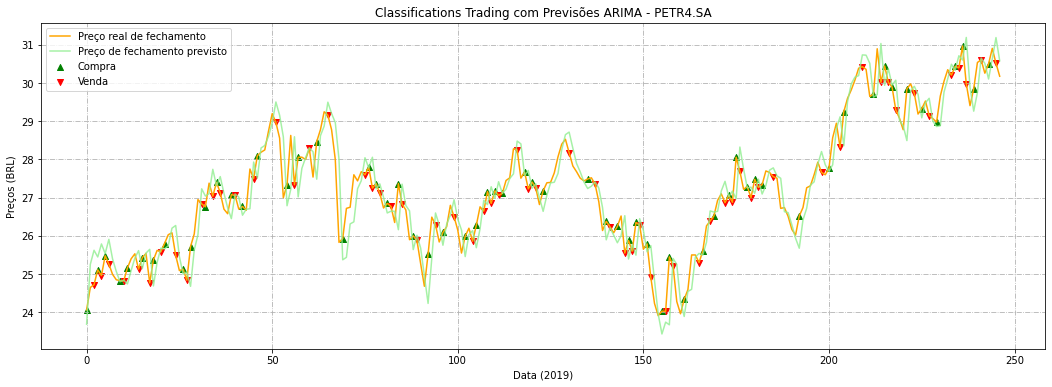

In [57]:
# Visualizando a operação ARIMA
operation_plot(actual_prices, 
               arima_trading[-1],
               "ARIMA",
               arima_pred)

In [58]:
# Salvando resultados em um dicionário
trading_results = save_data(arima_trading[2], 
                            arima_trading[3], 
                            arima_trading[4],
                            arima_trading[5],
                            arima_trading[6],
                            arima_trading[7],
                            arima_trading[8], 
                            
                            labels=["Final Wallet", 
                                    "Wallets Diff", 
                                    "% Wallets Diff",
                                    "Score",
                                    "Loss",
                                    "Hits Accuracy",
                                    "Mean Gain"],
                            
                            model="ARIMA(5,0,2)", 
                            dictionary=trading_results) # ARIMA

ARIMA(5,0,2) Salvado com sucesso!


## CNN

In [59]:
# Operação de trading com movimentos previstos CNN
cnn_trading = classifications_trading(actual_prices, 
                                      cnn_pred_movs, 
                                      model="CNN",
                                      show_results=True)

----------------------------------------------------------------
+-----+
| CNN |
+-----+
Initial Wallet: 100000.0
Final Wallet: 110859.98349999997
Wallets Diff: 10859.983499999973
Percentage Wallets diff: 1.1085998349999997
Score: 35
Loss: 22
Hits Accuracy: 0.6140350877192983
Mean Gain: 190.526026315789
----------------------------------------------------------------


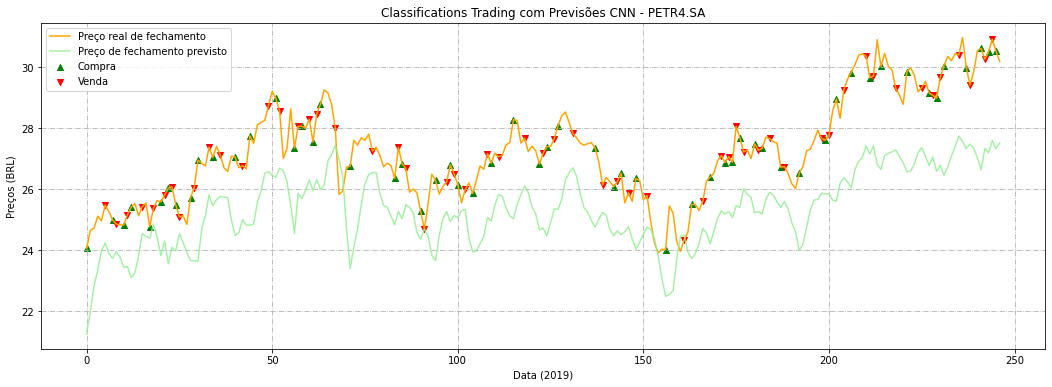

In [60]:
# Visualizando a operação CNN
operation_plot(actual_prices, 
               cnn_trading[-1],
               "CNN",
               cnn_pred_prices)

In [61]:
# Salvando resultados em um dicionário
trading_results = save_data(cnn_trading[2], 
                            cnn_trading[3], 
                            cnn_trading[4],
                            cnn_trading[5],
                            cnn_trading[6],
                            cnn_trading[7],
                            cnn_trading[8], 
                            
                            labels=["Final Wallet", 
                                    "Wallets Diff", 
                                    "% Wallets Diff",
                                    "Score",
                                    "Loss",
                                    "Hits Accuracy",
                                    "Mean Gain"],
                            
                            model="CNN", 
                            dictionary=trading_results) # CNN

CNN Salvado com sucesso!


## LSTM

In [62]:
# Operação de trading com movimentos previstos LSTM
lstm_trading = classifications_trading(actual_prices, 
                                       lstm_pred_movs, 
                                       model="LSTM", 
                                       show_results=True)

----------------------------------------------------------------
+------+
| LSTM |
+------+
Initial Wallet: 100000.0
Final Wallet: 103360.00750000002
Wallets Diff: 3360.0075000000215
Percentage Wallets diff: 1.0336000750000003
Score: 16
Loss: 17
Hits Accuracy: 0.48484848484848486
Mean Gain: 101.81840909091062
----------------------------------------------------------------


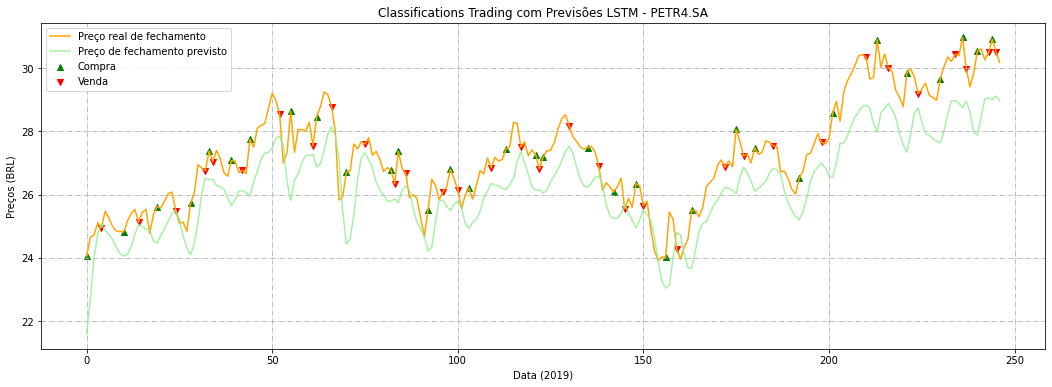

In [63]:
# Visualizando a operação LSTM
operation_plot(actual_prices, 
               lstm_trading[-1],
               "LSTM",
               lstm_pred_prices)

In [64]:
# Salvando resultados em um dicionário
trading_results = save_data(lstm_trading[2], 
                            lstm_trading[3], 
                            lstm_trading[4],
                            lstm_trading[5],
                            lstm_trading[6],
                            lstm_trading[7],
                            lstm_trading[8], 
                            
                            labels=["Final Wallet", 
                                    "Wallets Diff", 
                                    "% Wallets Diff",
                                    "Score",
                                    "Loss",
                                    "Hits Accuracy",
                                    "Mean Gain"],
                            
                            model="LSTM", 
                            dictionary=trading_results) # LSTM

LSTM Salvado com sucesso!


# Resultados

## Modelos

In [65]:
# Criando um DataFrame a partir do dicionário com os resultados dos modelos
df_model_results = pd.DataFrame(models_results)
df_model_results

,SMA10,SMA30,SMA50,AR,"ARMA(2,0,2)","ARIMA(5,0,2)",Naive1,Naive5,CNN,LSTM
Accuracy,0.589431,0.540650,0.520325,0.626016,0.491870,0.508130,0.491870,0.520325,0.544715,0.524390
MSE,0.550165,1.392854,2.068185,0.126310,0.272212,0.293134,0.244692,1.064078,4.456264,1.356165
R2,0.798460,0.489760,0.242368,0.953729,0.953729,0.891471,0.910363,0.610200,-0.632448,0.503201


### Comparação das previsões entre os modelos

In [66]:
# Criação de DataFrames com as previsões numéricas de cada modelo

# SMA10
df_sma10_pred = pd.DataFrame(sma_10[10:].values,
                             index=te.Date, 
                             columns=["Previsões SMA10"])

# SMA30
df_sma30_pred = pd.DataFrame(sma_30[30:].values,
                             index=te.Date, 
                             columns=["Previsões SMA30"])

# SMA50
df_sma50_pred = pd.DataFrame(sma_50[50:].values,
                             index=te.Date, 
                             columns=["Previsões SMA50"])

# AR
df_ar_pred = pd.DataFrame(ar_pred,
                          index=te.Date, 
                          columns=["Previsões AR"])

# ARMA
df_arma_pred = pd.DataFrame(arma_pred.values, 
                            index=te.Date, 
                            columns=["Previsões ARMA"])

# ARIMA
df_arima_pred = pd.DataFrame(arima_pred, 
                             index=te.Date, 
                             columns=["Previsões ARIMA"])

# Naive1
df_naive1_pred = pd.DataFrame(naive_1[1:].values,
                              index=te.Date, 
                              columns=["Previsões Naive1"])

# Naive5
df_naive5_pred = pd.DataFrame(naive_5[5:].values,
                              index=te.Date, 
                              columns=["Previsões Naive5"])

# CNN
df_cnn_pred = pd.DataFrame(cnn_pred_prices, 
                           index=te.Date, 
                           columns=["Previsões CNN"])

# LSTM
df_lstm_pred = pd.DataFrame(lstm_pred_prices, 
                            index=te.Date, 
                            columns=["Previsões LSTM"])

In [67]:
# Concatenando todos os DataFrames para visualização unificada
df_pred_compare = pd.concat([df_sma10_pred,
                             df_sma30_pred,
                             df_sma50_pred,
                             df_ar_pred, 
                             df_arma_pred, 
                             df_arima_pred, 
                             df_naive1_pred,
                             df_naive5_pred,
                             df_cnn_pred, 
                             df_lstm_pred,
                             te.Close], axis=1)

# Primeiras 15 linhas
# Comparação entre as previsões dos modelos
df_pred_compare.head(15)

,Previsões SMA10,Previsões SMA30,Previsões SMA50,Previsões AR,Previsões ARMA,Previsões ARIMA,Previsões Naive1,Previsões Naive5,Previsões CNN,Previsões LSTM,Close
Date,,,,,,,,,,,
2019-01-02,22.330,24.009000,24.9758,23.210735,27.226828,23.686323,22.680000,21.490000,21.252359,21.593004,24.059999
2019-01-03,22.490,23.994000,24.9342,24.469609,24.170377,25.254291,24.059999,21.549999,21.990093,22.705275,24.650000
2019-01-04,22.675,23.958000,24.8996,24.782083,24.719551,25.622445,24.650000,21.680000,22.823778,23.976862,24.719999
2019-01-07,22.986,23.928333,24.8878,24.768971,24.802682,25.447436,24.719999,21.670000,23.351244,24.767307,25.110001
2019-01-08,23.257,23.921333,24.8686,25.164776,25.169958,25.788443,25.110001,22.680000,23.972162,25.067163,24.959999
2019-01-09,23.656,23.932333,24.8476,25.452005,25.041124,25.536637,24.959999,24.059999,24.238947,24.875895,25.480000
2019-01-10,24.027,23.962000,24.8288,25.058256,25.523570,25.908513,25.480000,24.650000,23.890404,24.744324,25.260000
2019-01-11,24.358,23.986667,24.8150,25.111300,25.333066,25.393956,25.260000,24.719999,23.728130,24.574249,24.990000
2019-01-14,24.676,23.964000,24.7856,25.139553,25.073687,25.067119,24.990000,25.110001,23.955647,24.336472,24.850000


## Operações de *trading*

In [68]:
# Criando um DataFrame a partir do dicionário com os resultados de trading
df_trading_results = pd.DataFrame(trading_results)
df_trading_results.head()

,AR,"ARMA(2,0,2)","ARIMA(5,0,2)",CNN,LSTM
Final Wallet,134110.0150,105564.99850,110709.9910,110859.9835,103360.0075
Wallets Diff,34110.0150,5564.99850,10709.9910,10859.9835,3360.0075
% Wallets Diff,1.3411,1.05565,1.1071,1.1086,1.0336
Score,43.0000,21.00000,25.0000,35.0000,16.0000
Loss,23.0000,41.00000,38.0000,22.0000,17.0000


# Referências

- SMA: https://pt.wikipedia.org/wiki/M%C3%A9dia_m%C3%B3vel
- AR: https://en.wikipedia.org/wiki/Autoregressive_model
- ARMA: https://pt.wikipedia.org/wiki/ARMA
- ARIMA: https://pt.wikipedia.org/wiki/ARIMA
- Artigo PIBIC: https://github.com/gprzy/report-pibic-2020-2021/blob/main/report-pibic-2020-2021.pdf